In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/classify_names/names/*.txt'))

['data/classify_names/names/Portuguese.txt', 'data/classify_names/names/Czech.txt', 'data/classify_names/names/Spanish.txt', 'data/classify_names/names/Italian.txt', 'data/classify_names/names/Chinese.txt', 'data/classify_names/names/Greek.txt', 'data/classify_names/names/Irish.txt', 'data/classify_names/names/Japanese.txt', 'data/classify_names/names/Vietnamese.txt', 'data/classify_names/names/French.txt', 'data/classify_names/names/Arabic.txt', 'data/classify_names/names/Russian.txt', 'data/classify_names/names/German.txt', 'data/classify_names/names/Scottish.txt', 'data/classify_names/names/Dutch.txt', 'data/classify_names/names/Korean.txt', 'data/classify_names/names/English.txt', 'data/classify_names/names/Polish.txt']


In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn' 
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/classify_names/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    category_lines[category] = readLines(filename)

n_categories = len(all_categories)

In [12]:
for cat in category_lines.keys():
    print(cat, category_lines[cat][:5])

Portuguese ['Abreu', 'Albuquerque', 'Almeida', 'Alves', 'Araujo']
Czech ['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch']
Spanish ['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']
Italian ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
Chinese ['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']
Greek ['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']
Irish ['Adam', 'Ahearn', 'Aodh', 'Aodha', 'Aonghuis']
Japanese ['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara']
Vietnamese ['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']
French ['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']
Arabic ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
Russian ['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin']
German ['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles']
Scottish ['Smith', 'Brown', 'Wilson', 'Campbell', 'Stewart']
Dutch ['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven']
Korean ['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']
English ['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']
Pol

In [13]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('A'))
print(lineToTensor('David').size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    1     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([5, 1, 57])


In [21]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden= 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [23]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.8866 -2.8752 -2.9552 -2.8372 -2.9028 -2.9910 -2.9213 -2.8160 -2.8737 -2.9005

Columns 10 to 17 
-2.9271 -2.8272 -2.8763 -2.8766 -2.9267 -2.9085 -2.8475 -2.8940
[torch.FloatTensor of size 1x18]



In [24]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 7)


In [25]:
import random

def randomChoice(x):
    return x[random.randint(0, len(x) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Wan
category = Vietnamese / line = Kieu
category = Japanese / line = Inaba
category = Vietnamese / line = Diep
category = Irish / line = Bradach
category = Greek / line = Pezos
category = English / line = Yeadon
category = German / line = Kaiser
category = Polish / line = Chlebek
category = Russian / line = Mikhalitsin


In [26]:
criterion = nn.NLLLoss()

In [30]:
learning_rate = 5e-3

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.data[0]

In [31]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

In [32]:
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 21s) 2.5134 Cardozo / Portuguese ✓
10000 10% (0m 43s) 1.1371 Dubatolov / Russian ✓
15000 15% (1m 5s) 1.6452 Kang / Chinese ✗ (Korean)
20000 20% (1m 27s) 0.7335 Henderson / Scottish ✓
25000 25% (1m 49s) 2.5610 Hanania / Portuguese ✗ (Arabic)
30000 30% (2m 11s) 1.5810 Chun / Korean ✓
35000 35% (2m 33s) 3.3823 Kosko / Polish ✗ (Czech)
40000 40% (2m 55s) 0.8896 Zeng / Chinese ✓
45000 45% (3m 18s) 0.4606 Lambert / French ✓
50000 50% (3m 41s) 0.6107 Shiratori / Japanese ✓
55000 55% (4m 5s) 2.1369 Aller / German ✗ (Dutch)
60000 60% (4m 28s) 0.5759 Cracchiolo / Italian ✓
65000 65% (4m 52s) 1.2584 Casales / Portuguese ✗ (Spanish)
70000 70% (5m 16s) 2.6276 Salinas / Greek ✗ (Spanish)
75000 75% (5m 39s) 1.1946 Geier / German ✓
80000 80% (6m 3s) 0.1379 Kasprzak / Polish ✓
85000 85% (6m 27s) 2.3851 De leon / English ✗ (Spanish)
90000 90% (6m 51s) 0.8651 Beyer / German ✓
95000 95% (7m 13s) 0.9718 Acciai / Italian ✓
100000 100% (7m 36s) 5.8937 Paulis / Greek ✗ (Dutch)


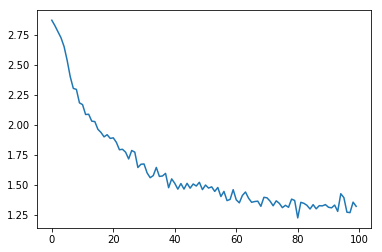

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [37]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

In [38]:
fig = plt.figure()
ax = fig.subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

AttributeError: 'Figure' object has no attribute 'subplot'